In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from scipy.stats import pearsonr, zscore, linregress
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm

In [2]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Helvetica'

In [3]:
#https://www.pnas.org/doi/suppl/10.1073/pnas.2302534120#supplementary-materials
#https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE202177
GSE202177 = pd.read_csv("GSE202177_normalized_gene_counts.csv")
GSE202177['sum_values'] = GSE202177.iloc[:, 1:].sum(axis=1)
GSE202177 = GSE202177[GSE202177['sum_values'] != 0]
GSE_T = GSE202177.T
GSE_T.columns = GSE_T.iloc[0]
GSE_T = GSE_T.drop(GSE_T.index[0])
GSE_T.reset_index(inplace=True)
GSE_T = GSE_T.rename(columns={'index': 'Sample ID'})
genes = pd.read_csv("HGNC_protein_coding_genes.txt", sep='\t')['Approved symbol'].tolist()
GSE_T_filtered = GSE_T[['Sample ID'] + [gene for gene in GSE_T.columns if gene in genes]]
#https://www.pnas.org/doi/suppl/10.1073/pnas.2302534120#supplementary-materials
phenotype = pd.read_csv("phenotype.csv")
phenotype['size_mosaicism'] = phenotype['CGG'].apply(lambda x: False if str(x).strip() == '>200' else True)
phenotype_methylation = phenotype[~phenotype['MPCR Methylation'].isin(['P', '-'])]
phenotype_methylation['methylation_mosaicism'] = phenotype['MPCR Methylation'].apply(lambda x: False if str(x).strip() in ['100% FM', '>200 100% FM'] else True)
phenotype_methylation['mosaicism'] = phenotype_methylation['methylation_mosaicism'] + phenotype_methylation['size_mosaicism']
phenotype_methylation_genex = pd.merge(phenotype_methylation, GSE_T_filtered, on='Sample ID')
phenotype_methylation_genex = phenotype_methylation_genex.dropna(subset=['IQ'])
phenotype_methylation_genex = phenotype_methylation_genex.dropna(subset=['ABC'])
phenotype_methylation_genex = phenotype_methylation_genex.dropna(subset=['PMBC [ng FMRP/ ug total protein]'])
phenotype_methylation_genex = phenotype_methylation_genex.apply(pd.to_numeric, errors='ignore')
excluded_cols = [
    'Lab ID', 'Sample ID', 'Gender', 'Age', 'Status', 'CGG', 
    'SB Methylation', 'MPCR Methylation', 
    'PMBC [ng FMRP/ ug total protein]', 
    'DBS [FMRP(ng/mL) /1000 WBC]', 'IQ', 'ABC', 
    'Com', 'DLS', 'Social', 'size_mosaicism', 
    'methylation_mosaicism', 'mosaicism'
]
cols_to_sum = phenotype_methylation_genex.columns.difference(excluded_cols)
column_sums = phenotype_methylation_genex[cols_to_sum].sum()
non_zero_cols = column_sums[column_sums > 0.5].index
detectable_genes = list(non_zero_cols)
phenotype_methylation_genex = phenotype_methylation_genex[excluded_cols + list(non_zero_cols)]

/var/folders/v1/3py01kc1619d4sj6bsmhx3br0000gn/T/ipykernel_57124/182737897.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_methylation['methylation_mosaicism'] = phenotype['MPCR Methylation'].apply(lambda x: False if str(x).strip() in ['100% FM', '>200 100% FM'] else True)
/var/folders/v1/3py01kc1619d4sj6bsmhx3br0000gn/T/ipykernel_57124/182737897.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_methylation['mosaicism'] = phenotype_methylation['methylation_mosaicism'] + phenotype

PearsonRResult(statistic=0.46625410570301545, pvalue=0.0686947291321532)


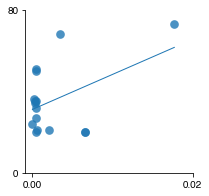

In [4]:
plt.rcParams['font.size'] = 12
plt.figure(figsize=(3, 3))
g = sns.regplot(x="PMBC [ng FMRP/ ug total protein]", y="ABC", data=phenotype_methylation_genex, ci=None,
                line_kws={"lw": 1}, scatter_kws={'linewidth': 0, 's': 75})
# Set the y-ticks
g.set_yticks([0, 80])
g.set_xticks([0, .02])
g.set_ylabel('')
g.set_xlabel('')
g.spines['top'].set_visible(False)
g.spines['right'].set_visible(False)
print(pearsonr(phenotype_methylation_genex['PMBC [ng FMRP/ ug total protein]'], phenotype_methylation_genex['ABC']))
#plt.savefig('Shah_FMRP_ABC.pdf',dpi=1000)

In [5]:
columns_to_exclude_1 = [
    'Lab ID', 'Sample ID', 'Gender', 'Age', 'Status', 'CGG', 
    'SB Methylation', 'MPCR Methylation',
    'PMBC [ng FMRP/ ug total protein]', 'DBS [FMRP(ng/mL) /1000 WBC]',
    'IQ', 'ABC', 'Com', 
    'DLS', 'Social', 'size_mosaicism', 'methylation_mosaicism', 'mosaicism',
]

gene_columns = [col for col in phenotype_methylation_genex.columns if col not in columns_to_exclude_1]
sample_gene = phenotype_methylation_genex[gene_columns]
median_genes = sample_gene.median(axis=0)
ratios = sample_gene.divide(median_genes)
median_ratios = ratios.median(axis=1)
normalized_sample_gene = ratios.divide(median_ratios, axis=0)
melted_df = normalized_sample_gene.melt(var_name="Gene", value_name="Counts", ignore_index=False)
melted_df['Sample'] = melted_df.index
melted_df = melted_df.reset_index(drop=True)
phenotype_methylation_genex = pd.merge(
    phenotype_methylation_genex[columns_to_exclude_1], 
    normalized_sample_gene, 
    left_index=True, 
    right_index=True
)
columns_to_exclude = [
    'Lab ID', 'Sample ID', 'Gender', 'Age', 'Status', 'CGG', 
    'SB Methylation', 'MPCR Methylation', 'IQ', 'ABC', 'Com', 
    'DLS', 'Social', 'size_mosaicism', 'methylation_mosaicism', 'mosaicism'
]

zscore_columns = [col for col in phenotype_methylation_genex.columns if col not in columns_to_exclude]
phenotype_methylation_genex[zscore_columns] = phenotype_methylation_genex[zscore_columns].apply(zscore)
columns_to_drop = phenotype_methylation_genex[zscore_columns].loc[
    :, (phenotype_methylation_genex[zscore_columns].abs() >= 3.5).any()
].columns
columns_to_exclude_1.extend(columns_to_drop.tolist())
phenotype_methylation_genex_cleaned = phenotype_methylation_genex.drop(columns=columns_to_drop)
phenotype_methylation_genex_cleaned = phenotype_methylation_genex.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='any')

PearsonRResult(statistic=-0.5247837767051596, pvalue=0.036877292389761784)


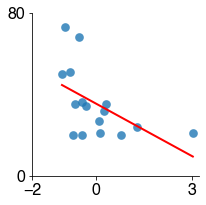

In [6]:
plt.rcParams['font.size'] = 16
plt.figure(figsize=(3, 3))
g = sns.regplot(x="SLITRK4", y="ABC", data=phenotype_methylation_genex_cleaned, ci=None,
                line_kws={"lw": 2, 'color':"r"}, scatter_kws={'linewidth': 0, 's': 75})
# Set the y-ticks
g.set_yticks([0, 80])
g.set_xticks([-2,0, 3])
g.set_ylabel('')
g.set_xlabel('')
g.spines['top'].set_visible(False)
g.spines['right'].set_visible(False)
print(pearsonr(phenotype_methylation_genex_cleaned['SLITRK4'], phenotype_methylation_genex_cleaned['ABC']))
#plt.savefig('Shah_SLITRK4_ABC.pdf',dpi=1000)

PearsonRResult(statistic=-0.5311969543654759, pvalue=0.03423005431286984)


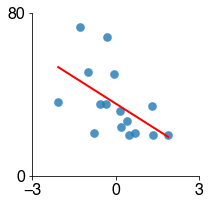

In [7]:
plt.figure(figsize=(3, 3))
g = sns.regplot(x="KHDRBS2", y="ABC", data=phenotype_methylation_genex_cleaned, ci=None,
                line_kws={"lw": 2, 'color':"r"}, scatter_kws={'linewidth': 0, 's': 75})
# Set the y-ticks
g.set_yticks([0, 80])
g.set_xticks([-3,0, 3])
g.set_ylabel('')
g.set_xlabel('')
g.spines['top'].set_visible(False)
g.spines['right'].set_visible(False)
print(pearsonr(phenotype_methylation_genex_cleaned['KHDRBS2'], phenotype_methylation_genex_cleaned['ABC']))
#plt.savefig('Shah_KHDRBS2_ABC.pdf',dpi=1000)

PearsonRResult(statistic=-0.4750144714007785, pvalue=0.06297493925064498)


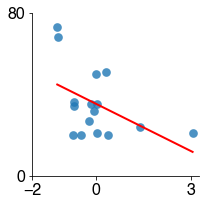

In [8]:
plt.figure(figsize=(3, 3))
g = sns.regplot(x="ANGEL2", y="ABC", data=phenotype_methylation_genex_cleaned, ci=None,
                line_kws={"lw": 2, 'color':"r"}, scatter_kws={'linewidth': 0, 's': 75})
# Set the y-ticks
g.set_yticks([0, 80])
g.set_xticks([-2,0, 3])
g.set_ylabel('')
g.set_xlabel('')
g.spines['top'].set_visible(False)
g.spines['right'].set_visible(False)
print(pearsonr(phenotype_methylation_genex_cleaned['ANGEL2'], phenotype_methylation_genex_cleaned['ABC']))
#plt.savefig('Shah_ANGEL2_ABC.pdf',dpi=1000)

PearsonRResult(statistic=0.8538406065698319, pvalue=2.572902708539774e-05)


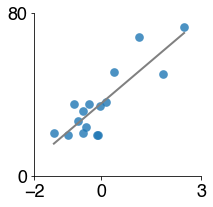

In [9]:
plt.rcParams['font.size'] = 18
plt.figure(figsize=(3, 3))
g = sns.regplot(x="PROC", y="ABC", data=phenotype_methylation_genex_cleaned, ci=None,
                line_kws={"lw": 2, 'color':"grey"}, scatter_kws={'linewidth': 0, 's': 75})
# Set the y-ticks
g.set_yticks([0, 80])
g.set_xticks([-2,0, 3])
g.set_ylabel('')
g.set_xlabel('')
g.spines['top'].set_visible(False)
g.spines['right'].set_visible(False)
print(pearsonr(phenotype_methylation_genex_cleaned['PROC'], phenotype_methylation_genex_cleaned['ABC']))
#plt.savefig('Shah_PROC_ABC.pdf',dpi=1000)

PearsonRResult(statistic=0.8510728669035408, pvalue=2.9113889883150594e-05)


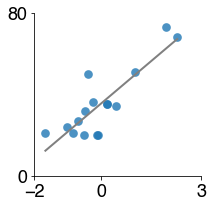

In [10]:
plt.figure(figsize=(3, 3))
g = sns.regplot(x="LDHB", y="ABC", data=phenotype_methylation_genex_cleaned, ci=None,
                line_kws={"lw": 2, 'color':"grey"}, scatter_kws={'linewidth': 0, 's': 75})
# Set the y-ticks
g.set_yticks([0, 80])
g.set_xticks([-2,0, 3])
g.set_ylabel('')
g.set_xlabel('')
g.spines['top'].set_visible(False)
g.spines['right'].set_visible(False)
print(pearsonr(phenotype_methylation_genex_cleaned['LDHB'], phenotype_methylation_genex_cleaned['ABC']))
#plt.savefig('Shah_LDHB_ABC.pdf',dpi=1000)